# RHF 偶极矩的核坐标导数

在这一章的最后，我们讨论一个相对复杂一些的导数，即偶极矩的核坐标导数 $d_s^{A_t} = \frac{\partial d_s}{\partial A_t}$。这个量结合频率分析，可以得到红外光谱；我们在这里会使用一个小程序绘制光谱图而不详细展开。

In [1]:
%matplotlib notebook

from pyscf import gto, scf, lib, prop
import numpy as np
from matplotlib import pyplot as plt
from pyxdh.Utilities import FormchkInterface, NucCoordDerivGenerator, NumericDiff
from pyxdh.Utilities.test_molecules import Mol_H2O2
from pyxdh.DerivOnce import DipoleSCF, GradSCF
from pyxdh.DerivTwice import DipDerivSCF
import warnings

warnings.filterwarnings("ignore")
np.set_printoptions(5, linewidth=150, suppress=True)

## 量化软件计算 RHF 偶极矩的核坐标导数

### Gaussian 偶极矩的核坐标导数

我们在 Hessian 的文档中已经展示 Gaussian 的偶极矩核坐标导数的求取了。这里展示一下结果：

In [2]:
fchk = FormchkInterface("assets/H2O2-freq.fch")
fchk.dipolederiv()

array([[-0.2343 ,  0.01785,  0.16617],
       [ 0.07423, -0.4948 ,  0.00587],
       [ 0.04888, -0.08356, -0.50397],
       [-0.41785,  0.01883, -0.16946],
       [ 0.00548, -0.32846, -0.15515],
       [ 0.02287,  0.03304, -0.09475],
       [ 0.21503,  0.00182, -0.03122],
       [-0.04486,  0.44397,  0.02416],
       [-0.03371, -0.01025,  0.25124],
       [ 0.43712, -0.0385 ,  0.03451],
       [-0.03485,  0.37929,  0.12513],
       [-0.03804,  0.06077,  0.34748]])

同时，我们也展示一下 Gaussian 计算得到的红外光谱强度 (单位为 km/mol)：

In [3]:
with open("assets/H2O2-freq.out", "r") as f:
    for idx, line in enumerate(f.readlines()):
        if "IR Inten" in line:
            print("line {:4d}:".format(idx + 1), line[:-1])

line  577:  IR Inten    --   195.2349               105.4141                99.7388
line  591:  IR Inten    --    17.5360                47.6775               105.1116


### pyxdh 偶极矩的核坐标导数

In [4]:
molh = Mol_H2O2()
mol = molh.mol
scf_eng = molh.hf_eng

In [5]:
diph = DipoleSCF({"scf_eng": scf_eng, "cphf_tol": 1e-10})
gradh = GradSCF({"scf_eng": scf_eng, "cphf_tol": 1e-10})
dipdh = DipDerivSCF({"deriv_A": diph, "deriv_B": gradh})
dipdh.E_2

array([[-0.2343 ,  0.07423,  0.04889, -0.41784,  0.00548,  0.02287,  0.21502, -0.04486, -0.03371,  0.43712, -0.03485, -0.03804],
       [ 0.01785, -0.4948 , -0.08356,  0.01883, -0.32846,  0.03304,  0.00182,  0.44397, -0.01025, -0.0385 ,  0.37929,  0.06077],
       [ 0.16618,  0.00587, -0.50398, -0.16946, -0.15515, -0.09475, -0.03122,  0.02416,  0.25124,  0.03451,  0.12513,  0.34748]])

上述的矩阵维度与 Gaussian 输出恰好是转置；在稍低的判定条件下，可以基本判断两矩阵近乎相等：

In [6]:
np.allclose(fchk.dipolederiv(), dipdh.E_2.T, atol=1e-5, rtol=1e-4)

True

## 偶极矩的核坐标导数的数值导数

### 三点差分数值导数

我们在之前的文档中，已经对原子和坐标与电场的三点差分进行过计算。这里的计算也大同小异，我们就不作更详细的说明了。但我们需要指出，由于带电场的分子梯度并不是非常容易求取的，因此我们使用数值梯度求导的策略是求出偶极矩后，对原子核坐标作数值导数。

譬如说，我们对第一个氧原子的 $x$ 坐标作导数求取。我们移动该坐标以产生两个分子 `mol_m1`, `mol_p1` 作核坐标导数的三点差分。

In [7]:
def gen_H2O2(coord):
    """
    Generate H2O2 molecule (with basis 6-31G)
    """
    mol = gto.Mole()
    mol.atom = """
    O  0.0  0.0  0.0
    O  0.0  0.0  1.5
    H  1.0  0.0  0.0
    H  0.0  0.7  1.0
    """
    mol.basis = "6-31G"
    mol.verbose = 0
    mol.build()
    mol.set_geom_(coord * lib.param.BOHR)
    return mol.build()

In [8]:
coord_orig = mol.atom_coords()
coord_m1 = coord_orig.copy()
coord_m1[0, 0] -= 1e-4
coord_p1 = coord_orig.copy()
coord_p1[0, 0] += 1e-4
mol_m1 = gen_H2O2(coord_m1)
mol_p1 = gen_H2O2(coord_p1)

随后我们求取这两个分子的偶极矩，作三点差分：

In [9]:
dip_m1 = scf.RHF(mol_m1).run().dip_moment(unit="A.U.", verbose=0)
dip_p1 = scf.RHF(mol_p1).run().dip_moment(unit="A.U.", verbose=0)
(dip_p1 - dip_m1) / 2e-4

array([-0.2343 ,  0.01785,  0.16617])

我们会发现，上述导数的值与 Gaussian 输出的值相等：

In [10]:
fchk.dipolederiv()[0]

array([-0.2343 ,  0.01785,  0.16617])

### pyxdh 数值导数

我们的被求导量既然是原子核坐标，那么我们的实例化的类是 `NucCoordDerivGenerator`，而非 `DipoleDerivGenerator`。我们使用与求取 Hessian 时相似的生成方式；但计算实例可以是 `scf.RHF` 类而非 `grad.RHF` 类，因为 `scf.RHF` 类可以直接导出作为被求导量的偶极矩：

In [11]:
generator = NucCoordDerivGenerator(mol, lambda mol_: scf.RHF(mol_).run())
diff = NumericDiff(generator, lambda mf: mf.dip_moment(unit="A.U.", verbose=0))

使用 `derivative` property，就可以求出该分子的数值偶极矩的核坐标导数：

In [12]:
diff.derivative

array([[-0.2343 ,  0.01785,  0.16617],
       [ 0.07423, -0.4948 ,  0.00587],
       [ 0.04889, -0.08356, -0.50398],
       [-0.41785,  0.01883, -0.16946],
       [ 0.00548, -0.32846, -0.15516],
       [ 0.02286,  0.03304, -0.09474],
       [ 0.21502,  0.00182, -0.03122],
       [-0.04486,  0.44397,  0.02416],
       [-0.03371, -0.01025,  0.25124],
       [ 0.43712, -0.0385 ,  0.03451],
       [-0.03485,  0.37929,  0.12514],
       [-0.03804,  0.06077,  0.34748]])

我们可以将其与 Gaussian 的输出结果作对照：

In [13]:
np.allclose(diff.derivative, fchk.dipolederiv(), atol=1e-5, rtol=1e-4)

True

## 红外光谱绘制

<div class="alert alert-warning">

**提醒**

我们讨论的双氧水分子并非处于稳定构象，因此我们所得的分子频率和红外光谱并非是有物理意义的。后文所给的计算过程仅仅是演示而已。通过频率分析得到的红外光谱一般被认为处在稳定结构时才有讨论的意义。

</div>

我们最后陈述一下偶极矩的原子核坐标导数可以用于模拟红外光谱。下面的程序仍然借用了外部的 [freqanal.py](freqanal.py)。

In [14]:
from freqanal import FreqAnal, FactIR

我们首先需要通过 Hessian 矩阵得到频率信息 (单位 1/cm)：

In [15]:
mol_weight = np.array([15.99491, 15.99491, 1.00783, 1.00783])
frq = FreqAnal(mol_weight=mol_weight, mol_coord=mol.atom_coords(), hessian=fchk.hessian())
frq.freq

array([-1580.60525, -1218.37861,  1370.61982,  1647.53904,  3389.8587 ,  5347.88911])

随后，通过分子振动的简正坐标与偶极的核坐标导数作内积 (即求出分子在简正运动下，偶极矩的瞬时变化大小)，可以给出每个分子振动下的红外积分强度 (单位 km/mol)：

In [16]:
dipderiv_mode = np.einsum("Ar, Aq -> qr", diff.derivative, frq.q) * FactIR
ir_intensities = (dipderiv_mode ** 2).sum(axis=1)
ir_intensities

array([195.23468, 105.41248,  99.73978,  17.53655,  47.67743, 105.11221])

上面的向量值与 Gaussian 输出的红外光谱大小近乎相等：

In [17]:
with open("assets/H2O2-freq.out", "r") as f:
    for idx, line in enumerate(f.readlines()):
        if "IR Inten" in line:
            print("line {:4d}:".format(idx + 1), line[:-1])

line  577:  IR Inten    --   195.2349               105.4141                99.7388
line  591:  IR Inten    --    17.5360                47.6775               105.1116


上面是积分的红外光谱强度；模拟红外光谱时，还需要指定半峰宽峰的展宽程度。在这里，我们假定半峰宽都是 $50 \, \mathsf{cm}^{-1}$；并且展宽模式是 Lorentzian 型。那么，红外光谱图就绘制如下：

In [18]:
def lorentzian_freq(omega, omega_n, gamma):
    return 100 * 0.5 / np.pi * gamma / ((omega - omega_n)**2 + 0.25 * gamma**2)

def ir_plot(omega, gamma, freq, ir):
    val = 0
    assert(len(freq) == len(ir))
    for i in range(len(freq)):
        val += lorentzian_freq(omega, freq[i], gamma) * ir[i]
    return val

<IPython.core.display.Javascript object>


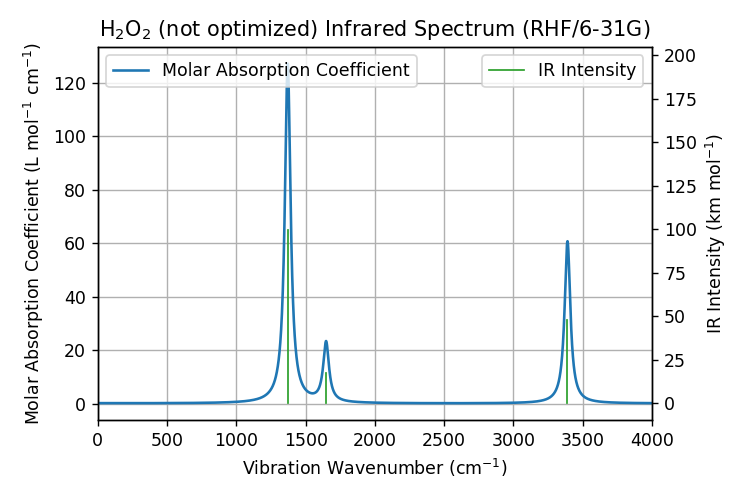

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.grid()

x = np.arange(0, 4000, 1)
ax.plot(x, ir_plot(x, 50, frq.freq, ir_intensities), label="Molar Absorption Coefficient")
ax.set_ylabel("Molar Absorption Coefficient (L mol$^{-1}$ cm$^{-1}$)")
ax.set_xlabel("Vibration Wavenumber (cm$^{-1}$)")
ax.set_title("H$_2$O$_2$ (not optimized) Infrared Spectrum (RHF/6-31G)")
ax.set_xlim(0, 4000)
ax.legend(loc="upper left")

ax2 = ax.twinx()
for i in range(ir_intensities.size):
    if i == 0:
        ax2.plot([frq.freq[i], frq.freq[i]], [0, ir_intensities[i]], c="C2", linewidth=1, label="IR Intensity")
    else:
        ax2.plot([frq.freq[i], frq.freq[i]], [0, ir_intensities[i]], c="C2", linewidth=1)
ax2.set_ylabel("IR Intensity (km mol$^{-1}$)")
ax2.legend(loc="upper right")
fig.tight_layout()